In [1]:
import os
import glob
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import time_utils
from unseen import indices
from unseen import general_utils

In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
shapefile = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
metadata_file = "/home/599/dbi599/forks/unseen/config/dataset_agcd_daily.yml"
rx15day_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
region_name = "east-coast-flood-region"


In [4]:
assert os.path.isfile(metadata_file), "Must provide a metadata file (papermill option -p metadata_file [filepath])"
assert os.path.isfile(shapefile), "Must provide a shapefile (papermill option -p shapefile [filepath])"
assert 'rx15day_file' in locals(), "Must provide an rx15day output file (papermill option -p rx15day_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

## Generate Rx15day data

In [5]:
agcd_files = glob.glob('/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_*_daily.nc')
agcd_files.sort()

In [6]:
#test = fileio.open_dataset(
#    agcd_files,
#    chunks={'time': 8000, 'lat': 40, 'lon': 40},
#    metadata_file=metadata_file,
#    shapefile=shapefile,
#    variables=['pr'],
#    spatial_agg='mean',
#    input_freq='D',
#    rolling_sum_window=15,
#    time_freq='A-AUG',    
#    time_agg='max',
#)

In [7]:
ds_list = []
for infile in agcd_files:
    print(infile)
    ds = fileio.open_dataset(
        infile,
        metadata_file=metadata_file,
        shapefile=shapefile,
        variables=['pr'],
        spatial_agg='mean', 
    )
    ds = ds.compute()
    ds_list.append(ds)

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19000101-19001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19010101-19011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19020101-19021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19030101-19031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19040101-19041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19050101-19051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19060101-19061231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19070101-19071231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19080101-19081231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19090101-19091231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19100101-19101231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19990101-19991231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20000101-20001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20010101-20011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20020101-20021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20030101-20031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20040101-20041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20050101-20051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

In [8]:
ds = xr.concat(ds_list, dim='time')

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 44641)
Coordinates:
  * time     (time) object 1900-01-01 09:00:00 ... 2022-03-22 09:00:00
Data variables:
    pr       (time) float32 2.617 0.2759 0.1095 0.3672 ... 3.118 0.1763 0.01809
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [10]:
ds = ds.compute()

In [11]:
clim = ds.groupby('time.month').mean()
clim

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (month) float32 3.911 4.512 3.925 2.809 ... 1.626 2.32 2.832 3.37

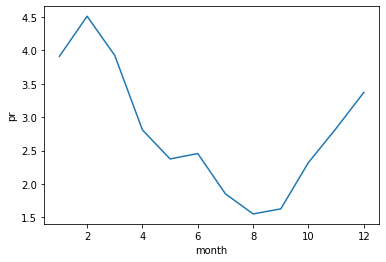

In [12]:
clim['pr'].plot()

In [13]:
ds_15day = ds.rolling({'time': 15}).sum()
ds_rx15day = time_utils.temporal_aggregation(ds_15day, 'A-AUG', 'D', 'max', ['pr'])

In [14]:
ds_rx15day

<xarray.Dataset>
Dimensions:  (time: 123)
Coordinates:
  * time     (time) object 1900-08-31 00:00:00 ... 2022-08-31 00:00:00
Data variables:
    pr       (time) float64 157.2 154.2 108.1 113.4 ... 124.4 288.8 287.6 410.4
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [15]:
time_stamp = datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y")
ds_rx15day.attrs['history'] = f'{time_stamp}: /home/599/dbi599/east-coast-rain/AGCD_{region_name}.ipynb (git@github.com:AusClimateService/east-coast-rain)'
fileio.to_zarr(ds_rx15day, rx15day_file)

## Analyse and plot Rx15day data

In [5]:
ds_rx15day = fileio.open_dataset(rx15day_file)

In [6]:
ds_rx15day

<xarray.Dataset>
Dimensions:  (time: 123)
Coordinates:
  * time     (time) object 1900-08-31 00:00:00 ... 2022-08-31 00:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(123,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

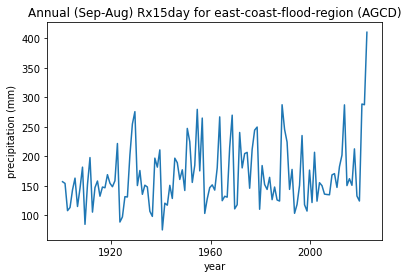

In [7]:
ds_rx15day['pr'].plot()
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

In [8]:
years = ds_rx15day['time'].dt.year.values
df_rx15day = pd.DataFrame(index=years)
df_rx15day['pr'] = ds_rx15day['pr'].values

In [9]:
df_rx15day['pr'].sort_values(ascending=False).head(n=10)

2022    410.447266
2020    288.797241
2021    287.604523
1988    287.580048
2013    287.378784
1954    279.746124
1929    275.874847
1968    269.900116
1963    267.014404
1956    264.991974
Name: pr, dtype: float64

In [10]:
rx15day_max = df_rx15day['pr'].values.max()
print(rx15day_max)

410.447265625


In [29]:
def gev_analysis(ds, event, region, outfile=''):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[6, 4])
    gev_xvals = np.arange(0, 700)
    nbins = round((ds.max() - ds.min()) / 10)
    ds.plot.hist(bins=nbins, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region} (AGCD)')
    if outfile:
        plt.savefig(
            outfile,
            bbox_inches='tight',
            facecolor='white',
            dpi=dpi
        )
    plt.show()
    
    gev_data = gev.rvs(gev_shape, gev_loc, gev_scale, size=5000000)
    percentile, return_period = general_utils.event_in_context(gev_data, event, 'above')
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

Shape parameter: -0.06
Location parameter: 142.94
Scale parameter: 39.14


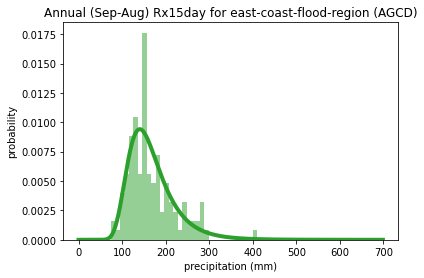

99.67% percentile
305 year return period



In [30]:
gev_analysis(
    df_rx15day['pr'],
    rx15day_max,
    region_name,
    outfile=f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_{region_name}.png'
)

Shape parameter: -0.01
Location parameter: 143.16
Scale parameter: 38.61


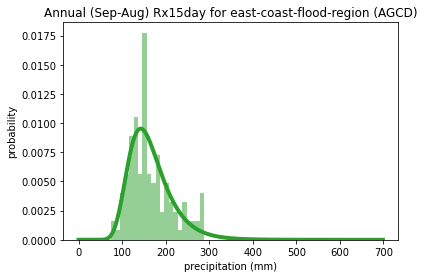

99.87% percentile
786 year return period



In [31]:
gev_analysis(
    df_rx15day['pr'][:-1],
    rx15day_max,
    region_name,
    outfile=f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_1900-2021_{region_name}.png'
)